# Project of Fundamentals of Artificial Intelligence and Knowledge Representation year 2022/2023

Made by Riccardo Murgia and Alessio Pellegrino
data source: https://www.kaggle.com/datasets/thedevastator/cancer-patients-and-air-pollution-a-new-link?resource=download

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from pgmpy.models import NaiveBayes, BayesianNetwork
from pgmpy.estimators import HillClimbSearch
from pgmpy.inference import VariableElimination

from function_definition import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

random_state = 42

# Data import and visualization


In [2]:
data = pd.read_csv('./dataset/cancer patient data sets.csv', index_col='index')
data.drop('Patient Id', axis=1, inplace=True)
target = 'Level'

data[target] = OrdinalEncoder(categories=[['Low', 'Medium', 'High']]).fit_transform(data[['Level']])
data.head()


,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
index,,,,,,,,,,,,,,,,,,,,,
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,0.0
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,1.0
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,2.0
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,2.0
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,2.0


## Analyzing the data

In [3]:
data.describe()


,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
count,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,37.174000,1.402000,3.8400,4.563000,5.165000,4.840000,4.580000,4.380000,4.491000,4.465000,...,3.856000,3.855000,4.240000,3.777000,3.746000,3.923000,3.536000,3.853000,2.926000,1.062000
std,12.005493,0.490547,2.0304,2.620477,1.980833,2.107805,2.126999,1.848518,2.135528,2.124921,...,2.244616,2.206546,2.285087,2.041921,2.270383,2.388048,1.832502,2.039007,1.474686,0.815365
min,14.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,27.750000,1.000000,2.0000,2.000000,4.000000,3.000000,2.000000,3.000000,2.000000,3.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000
50%,36.000000,1.000000,3.0000,5.000000,6.000000,5.000000,5.000000,4.000000,4.000000,4.000000,...,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,1.000000
75%,45.000000,2.000000,6.0000,7.000000,7.000000,7.000000,7.000000,6.000000,7.000000,7.000000,...,5.000000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,4.000000,2.000000
max,73.000000,2.000000,8.0000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000,7.000000,...,9.000000,8.000000,9.000000,8.000000,8.000000,9.000000,7.000000,7.000000,7.000000,2.000000


## Checking for NA values

In [4]:
np.sum(pd.isnull(data), 0)


Age                         0
Gender                      0
Air Pollution               0
Alcohol use                 0
Dust Allergy                0
OccuPational Hazards        0
Genetic Risk                0
chronic Lung Disease        0
Balanced Diet               0
Obesity                     0
Smoking                     0
Passive Smoker              0
Chest Pain                  0
Coughing of Blood           0
Fatigue                     0
Weight Loss                 0
Shortness of Breath         0
Wheezing                    0
Swallowing Difficulty       0
Clubbing of Finger Nails    0
Frequent Cold               0
Dry Cough                   0
Snoring                     0
Level                       0
dtype: int64

## Let's take a look to the distribution of the data

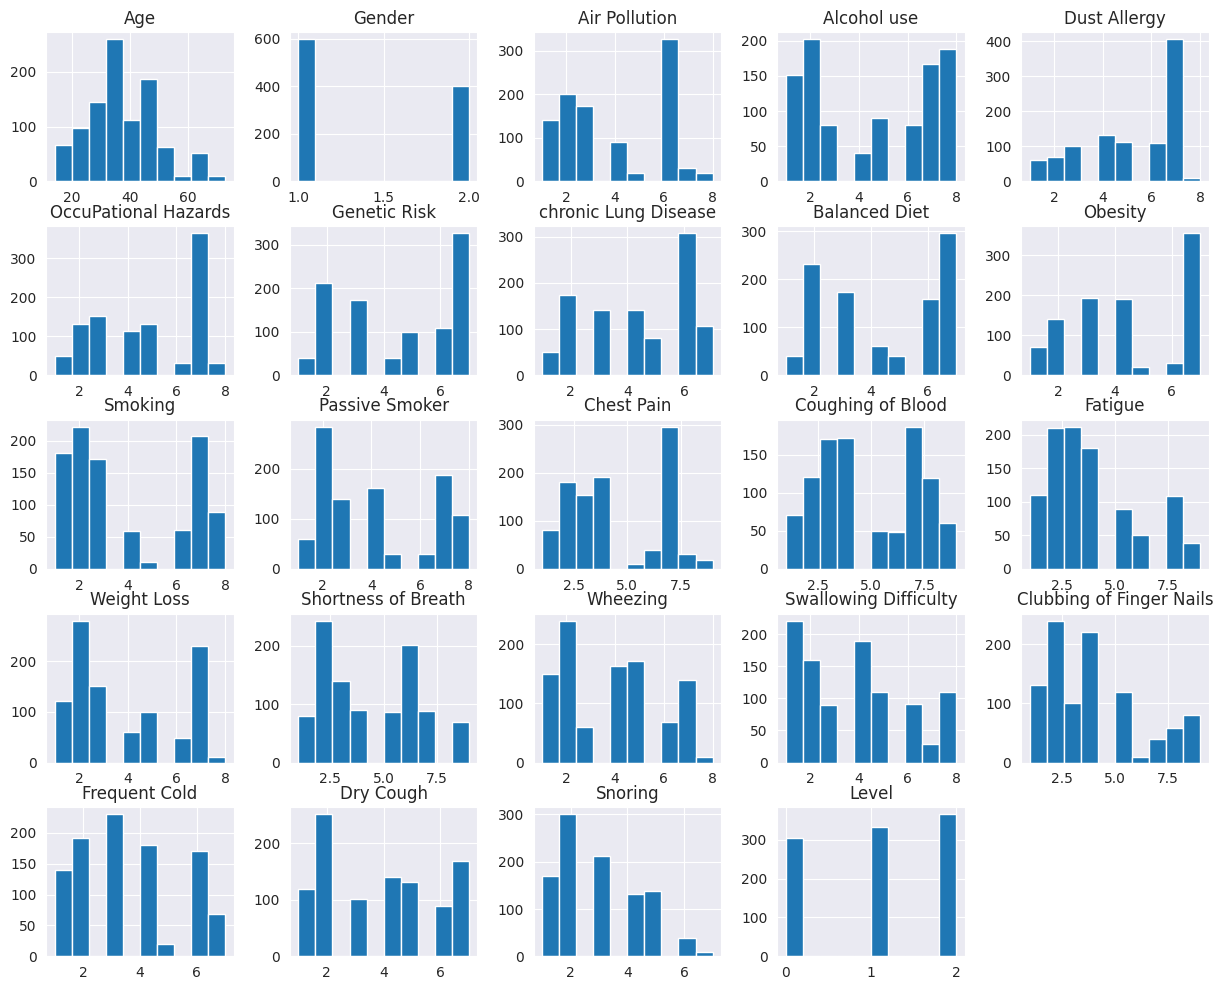

In [5]:
data.hist(figsize=(15,12));

In [6]:
columns = ['Age' ]
bins_edges = {'Age':[0, 18, 30, 60, 100]}
categories = {'Age':['child', 'young adult','adult', 'elder']}

data = discretize(data.copy(), columns, bins_edges, categories=categories)


## Let’s take a look to the correlation of the data

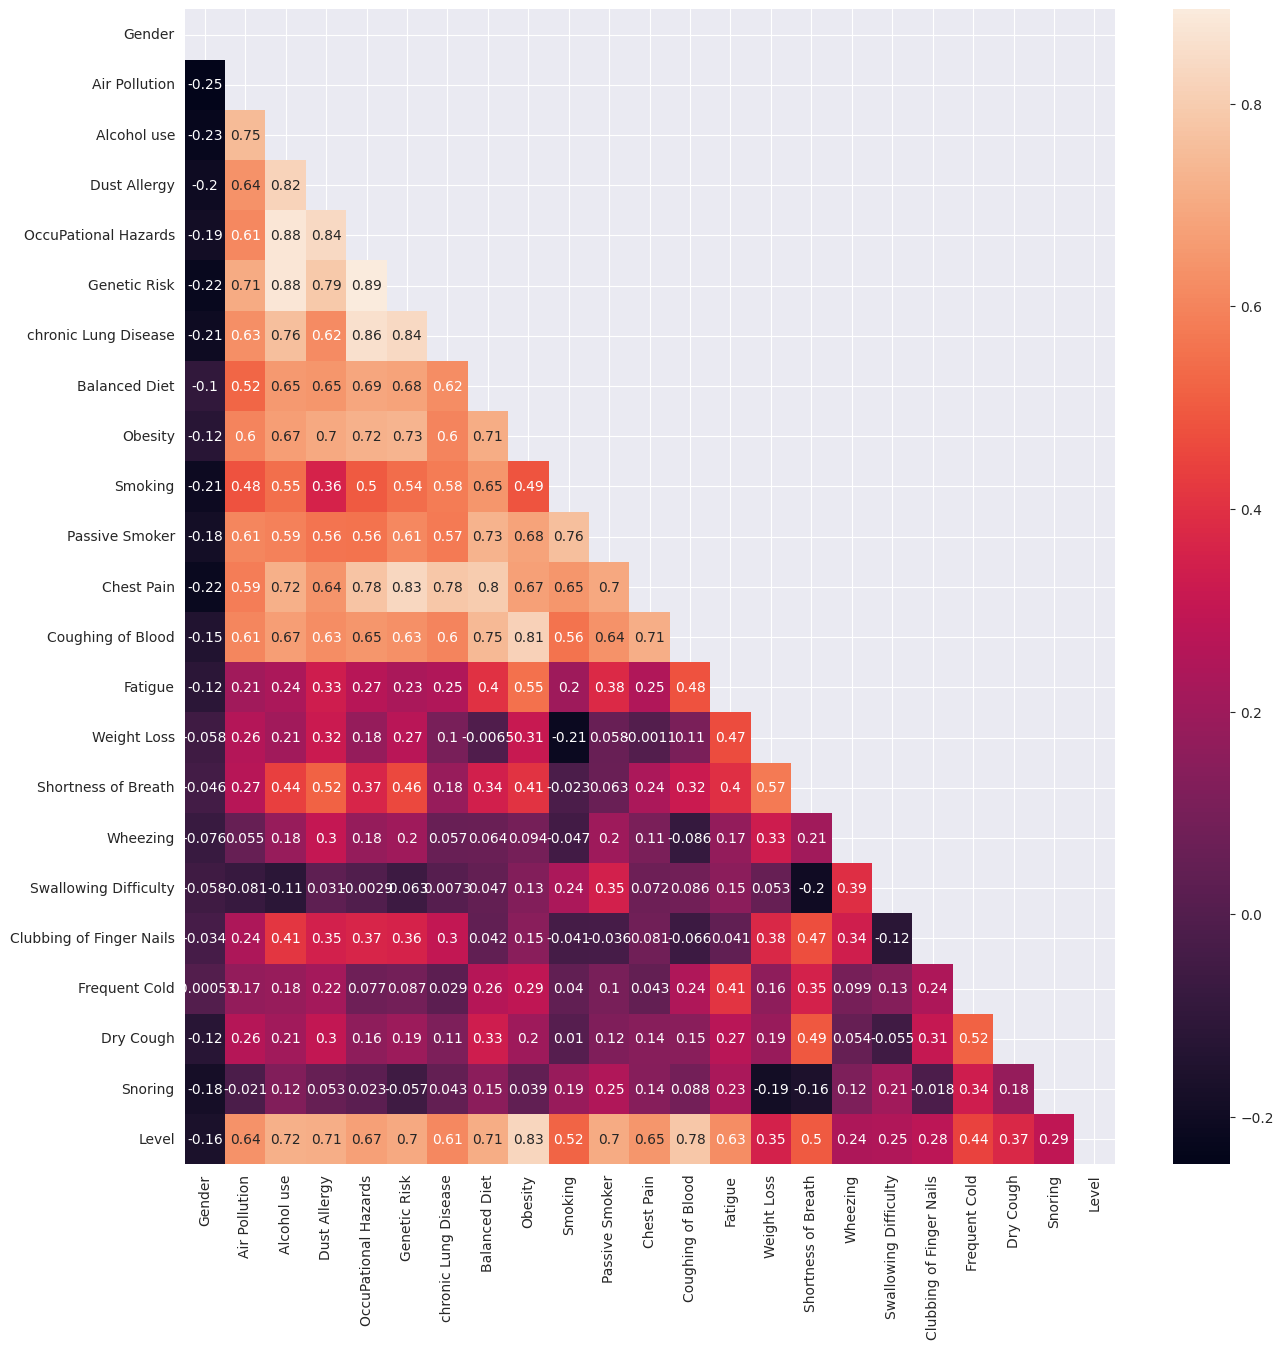

In [7]:
plt.figure(figsize=(15,15))
corr = data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,annot=True, mask=mask);


# Classification Process

## Models definition

In [8]:
data.columns = [node.replace(" ", "\n").lower() for node in data.columns.values]
target = target.lower()
data_train, data_test = train_test_split(data, random_state=random_state)


### Naive Bayes model

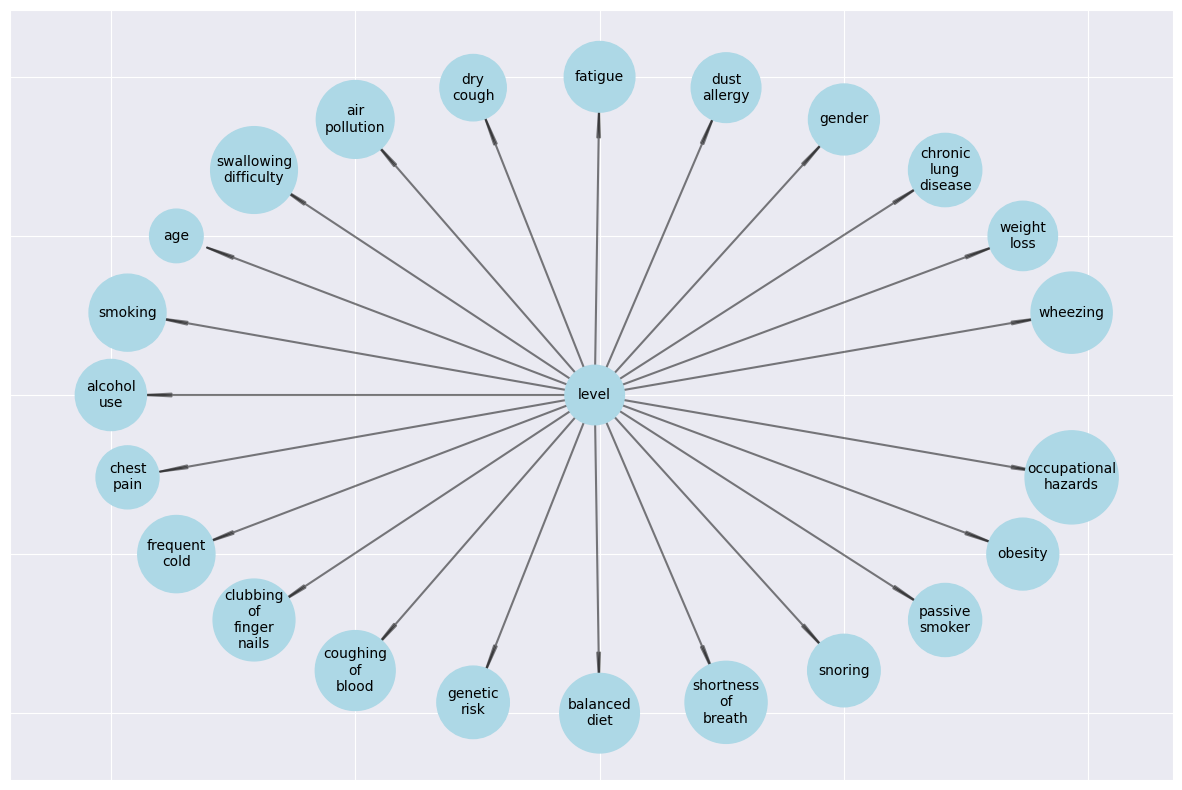

In [9]:
nb_model = NaiveBayes(
    feature_vars=data.columns.values[data.columns.values != target],
    dependent_var=target)
draw_net(data.columns.values, nb_model, style='circular', target='level')


### Model with all features

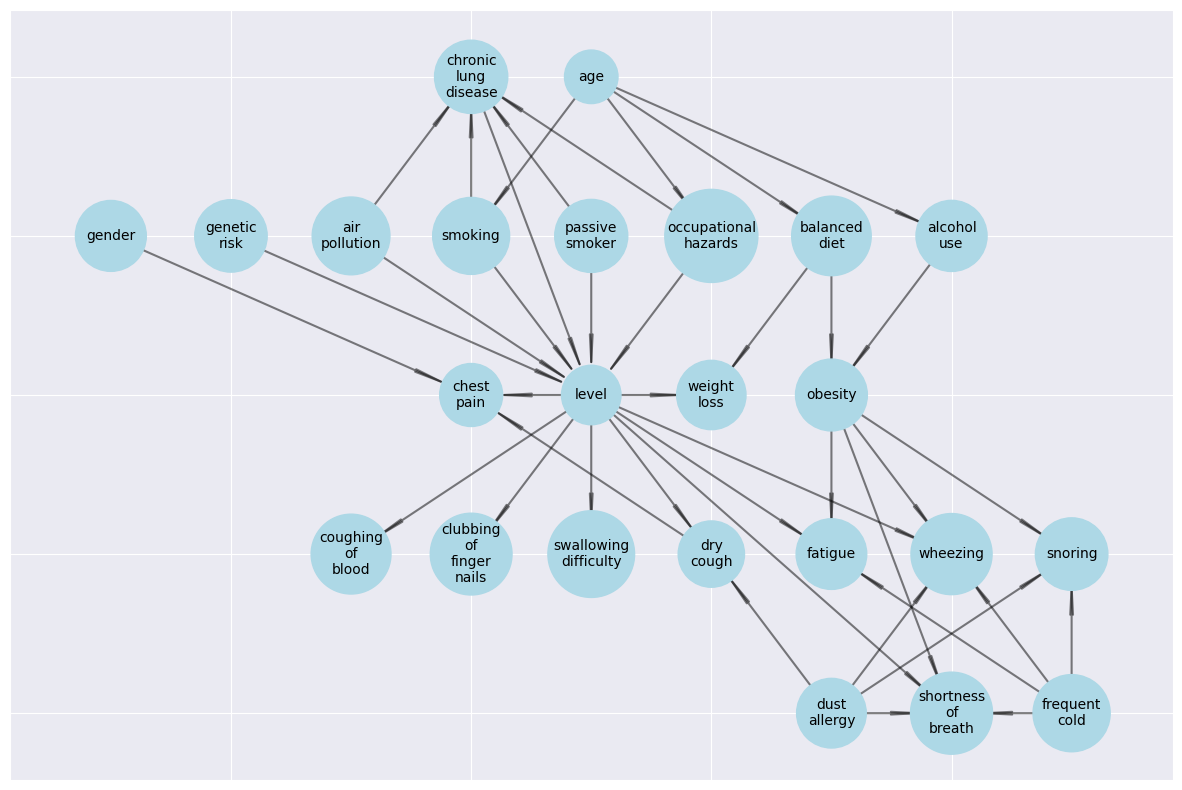

In [10]:
full_nodes_set = [
    'Chronic lung disease', 'Age', 'Gender', 'Genetic risk', 'Air pollution', 'Smoking', 'Passive smoker', 'Occupational Hazards', 'Balanced diet',
    'Alcohol use', 'Chest pain', 'Level', 'Weight loss', 'Obesity', 'Coughing of blood', 'Clubbing of finger nails', 'Swallowing difficulty',
    'Dry cough', 'Fatigue', 'Wheezing', 'Snoring', 'Dust allergy', 'Shortness of breath', 'Frequent cold'
    ]

full_nodes_set = [node.replace(" ", "\n").lower() for node in full_nodes_set]

arcs = [
    ('age', 'smoking'), ('age', 'occupational hazards'), ('age', 'balanced diet'), ('age', 'alcohol use'),
    ('air pollution', 'level'),  ('chronic lung disease', 'level'), ('smoking', 'level'), ('passive smoker', 'level'), ('occupational hazards', 'level'), 
    ('genetic risk', 'level'), 
    ('level', 'chest pain'), ('level', 'dry cough'), ('level', 'clubbing of finger nails'), ('level', 'coughing of blood'), ('level', 'swallowing difficulty'),
    ('level', 'fatigue'), ('level', 'wheezing'), ('level', 'shortness of breath'), ('level', 'weight loss'), 
    ('air pollution', 'chronic lung disease'), ('smoking', 'chronic lung disease'), ('passive smoker', 'chronic lung disease'), 
    ('occupational hazards', 'chronic lung disease'), 
    ('balanced diet', 'weight loss'), ('balanced diet', 'obesity'), 
    ('alcohol use' , 'obesity'), 
    ('gender', 'chest pain' ), ('dry cough', 'chest pain'),
    ('obesity', 'fatigue'), ('obesity', 'wheezing'), ('obesity', 'shortness of breath'), ('obesity', 'snoring'), 
    ('dust allergy', 'dry cough'), ('dust allergy', 'wheezing'), ('dust allergy', 'snoring'), ('dust allergy', 'shortness of breath'), 
    ('frequent cold', 'wheezing'), ('frequent cold', 'snoring'), ('frequent cold', 'shortness of breath'), ('frequent cold', 'fatigue') 
    ]

arcs = [(t[0].replace(" ", "\n"), t[1].replace(" ", "\n")) for t in arcs]

full_bn_model = BayesianNetwork(arcs)
draw_net(full_nodes_set, full_bn_model)

### Model without unused features

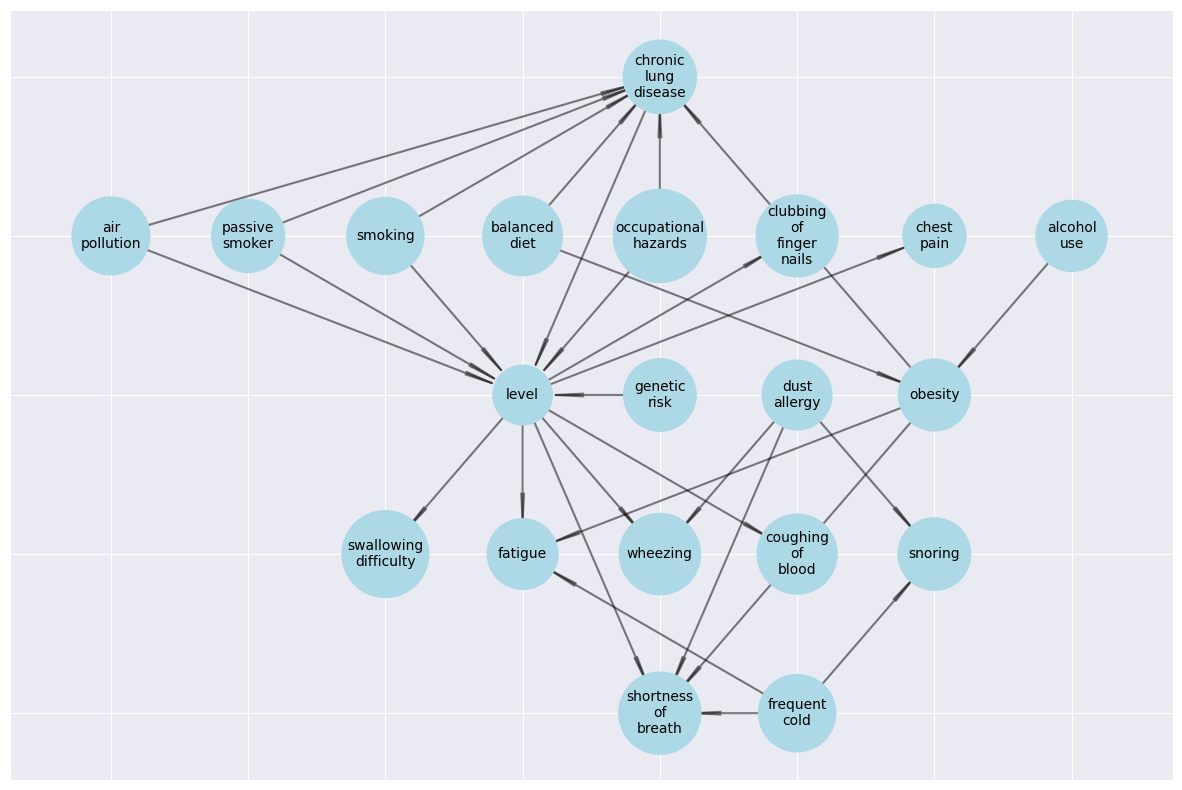

In [11]:
trimmed_nodes = [
    'chronic lung disease',  'air pollution', 'passive smoker', 'smoking',
    'balanced diet', 'occupational hazards', 'clubbing of finger nails', 'chest pain', 'alcohol use', 'level', 'genetic risk', 'dust allergy', 'obesity', 'swallowing difficulty',
    'fatigue', 'wheezing', 'coughing of blood', 'snoring','shortness of breath','frequent cold'
    ]


arcs = [
    ('air pollution', 'level'),  ('chronic lung disease', 'level'), ('smoking', 'level'), ('passive smoker', 'level'), ('occupational hazards', 'level'), 
    ('genetic risk', 'level'), 
    ('level', 'clubbing of finger nails'), ('level', 'chest pain'), ('level', 'coughing of blood'), ('level', 'swallowing difficulty'), ('level', 'fatigue'), 
    ('level', 'wheezing'), ('level', 'shortness of breath'), 
    ('air pollution', 'chronic lung disease'), ('smoking', 'chronic lung disease'), ('passive smoker', 'chronic lung disease'), 
    ('occupational hazards', 'chronic lung disease'), ('balanced diet', 'chronic lung disease'), ('obesity', 'chronic lung disease'), 
    ('balanced diet', 'obesity'), ('alcohol use' , 'obesity'), 
    ('obesity', 'fatigue'), ('obesity', 'shortness of breath'), 
    ('dust allergy', 'wheezing'), ('dust allergy', 'snoring'), ('dust allergy', 'shortness of breath'), 
    ('frequent cold', 'snoring'), ('frequent cold', 'shortness of breath'), ('frequent cold', 'fatigue') 
    ]


trimmed_nodes = [node.replace(" ", "\n") for node in trimmed_nodes]
arcs = [(t[0].replace(" ", "\n"), t[1].replace(" ", "\n")) for t in arcs]

trimmed_bn_model = BayesianNetwork(arcs)
draw_net(trimmed_nodes, trimmed_bn_model, style='trimmed')

### Model using the PGMPY HillClimbSearch method to build the graph

  0%|          | 0/1000000 [00:00<?, ?it/s]

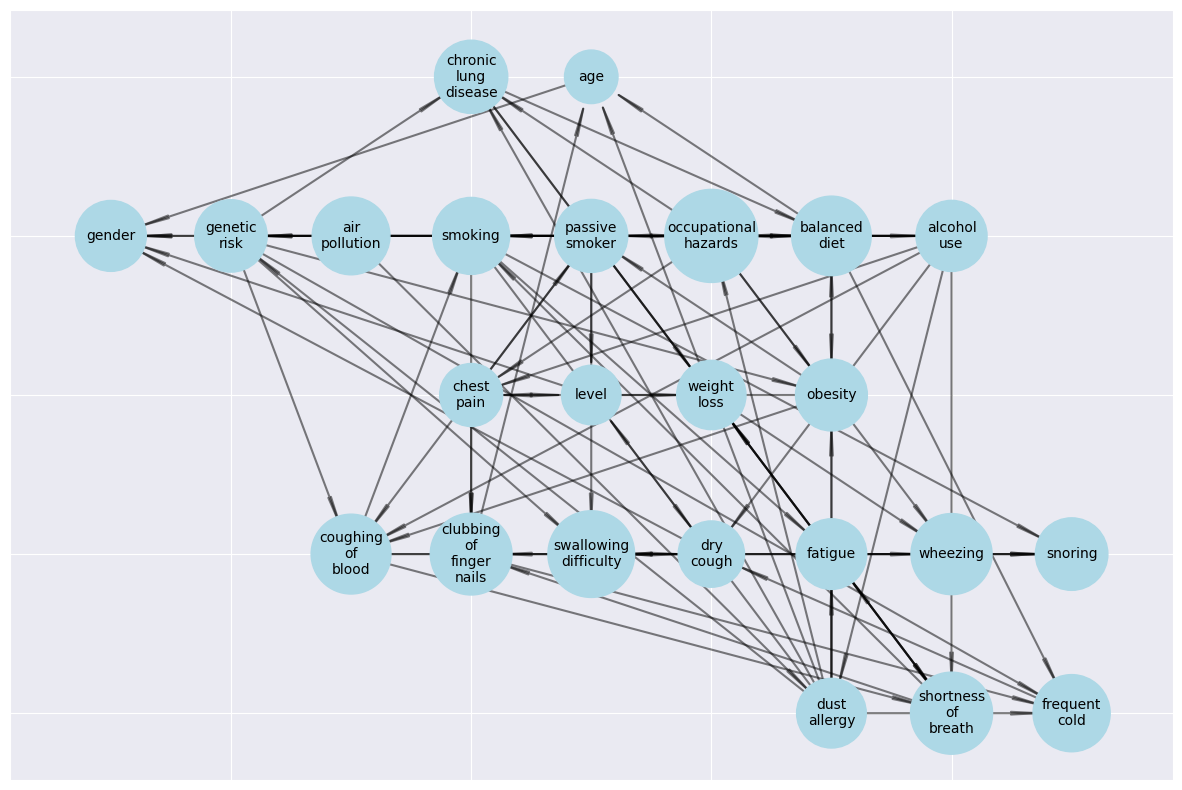

In [12]:
auto_bn = BayesianNetwork(HillClimbSearch(data=data_train).estimate())
draw_net(full_nodes_set, auto_bn)


## Models data fit

In [13]:
nb_model.fit(data_train)
full_bn_model.fit(data_train)
trimmed_bn_model.fit(data_train[trimmed_nodes])
auto_bn.fit(data_train)


# Predict

In [14]:
X_train, y_train = data_train.drop(target, axis=1), data_train[target] 
X_test, y_test = data_test.drop(target, axis=1), data_test[target]


In [15]:
nb_cdps = nb_model.get_cpds()
if not nb_model.check_model():
    print("model check failed")
nb_inference = VariableElimination(nb_model)
#print(predict(nb_inference, X_test, target))                       #FIXME

In [16]:
full_bn_cdps = full_bn_model.get_cpds()
if not full_bn_model.check_model():
    print("model check failed")
full_bn_inference = VariableElimination(full_bn_model)
posterior_probability_table_full_bn = get_the_posterior_probability(full_bn_inference, X_test, target)

/home/ric/PycharmProjects/Faikr_mod3/Bayesian_network_and_lung_cancer/venv/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


In [17]:
trimmed_bn_cdps = trimmed_bn_model.get_cpds()
if not trimmed_bn_model.check_model():
    print("model check failed")
trimmed_bn_inference = VariableElimination(trimmed_bn_model)
trimmed_nodes_X = trimmed_nodes.copy()
trimmed_nodes_X.remove(target)
posterior_probability_table_trimmed_bn = get_the_posterior_probability(trimmed_bn_inference, X_test[trimmed_nodes_X], target)

y_predicted = classify(posterior_probability_table_trimmed_bn)
print(y_predicted)

[1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0,

In [101]:
auto_bn_cdps = auto_bn.get_cpds()
if not auto_bn.check_model():
    print("model check failed")
auto_bn_inference = VariableElimination(auto_bn)
posterior_probability_table_trimmed_auto_bn = get_the_posterior_probability(auto_bn_inference, X_test, target)

/home/ric/PycharmProjects/Faikr_mod3/Bayesian_network_and_lung_cancer/venv/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


In [18]:
# Query example


evidence = {'chest\npain':4, 'age': 'child'}
query = ['level']

conditional_b_given_evidence = full_bn_inference.query(query, evidence=evidence)
print(conditional_b_given_evidence)


+------------+--------------+
| level      |   phi(level) |
+============+==============+
| level(0.0) |       0.3246 |
+------------+--------------+
| level(1.0) |       0.4329 |
+------------+--------------+
| level(2.0) |       0.2425 |
+------------+--------------+


In [97]:
evidence = {'chest\npain':4, 'age': 'child'}
query = ['gender']

posterior_probs = full_bn_inference.query(query, evidence=evidence)
predicted_class = posterior_probs.state_names[posterior_probs.variables[0]][np.argmax(posterior_probs.values)]


print(predicted_class)


1
